In [1]:
dependencies = [
    "fastai",
    "nbdev",
]

!pip install -U {" ".join(dependencies)}


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import gc

from fastai.imports import *
from fastai.vision.all import *

import matplotlib.pyplot as plt

In [3]:
# using a subset of ImageNet called Imagenette.
# It contains a subset of 10 very different categories from the original ImageNet dataset, 
# making for quicker training when we want to experiment.
path = untar_data(URLs.IMAGENETTE)
path.ls()

# This is going to be much harder to do well than with our previous datasets 
# because we're using full-size, full-color images, which are photos of objects of different sizes,
# in different orientations, in different lighting, and so forth.
#
# So, in this chapter we're going to introduce some important techniques 
# for getting the most out of your dataset, especially when you're training from scratch,
# or using transfer learning to train a model on a very different kind of dataset
# than the pretrained model used.

(#3) [Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/noisy_imagenette.csv'),Path('/root/.fastai/data/imagenette2/val')]

In [4]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

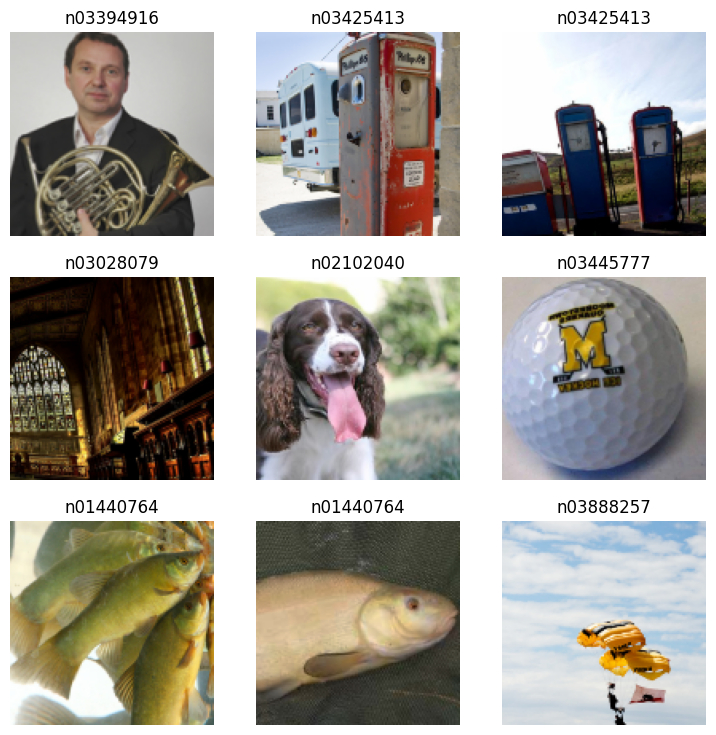

In [5]:

dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls = dblock.dataloaders(path, bs=128)
dls.show_batch()

In [6]:
dls.c

10

In [7]:
# we are going to train a model from scratch (not using transfer learning) 
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.564830,2.164561,0.454444,00:29
1,1.269781,1.290502,0.612397,00:28
2,1.032801,1.301036,0.606423,00:28
3,0.800898,0.722590,0.768111,00:28
4,0.645948,0.597270,0.811053,00:28


In [8]:
# accuracy is not great but it's actually a good baseline!
# because we are not using a pretrained model, but we can do better!
#
# When nworking with models that are being trained from scratch
# or fine-tuned to a very different dataset that the one used for the pretraining,
# ther are some additionals techniques that are really important.
#
# We we will consider some key approaches you want to be familiar with.
# The first one is NORMALIZING your data.
x,y = dls.one_batch()
x.shape

torch.Size([128, 3, 128, 128])

# Normalizing

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_std(data):
    # Calculate mean and standard deviation
    data = data.cpu()
    mean = data.mean()
    std_dev = data.std()

    # Plot the data
    plt.plot(data, label='Data')
    plt.axhline(mean, color='r', linestyle='--', label='Mean')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Mean and STD')

    # Add error bar
    plt.errorbar(0, mean, yerr=std_dev, fmt='o')

     # Add text for mean and standard deviation
    plt.text(0, mean, f'Mean: {mean.item():.2f}', ha='left', va='bottom', color='red')
    plt.text(0, mean + std_dev, f'Std Dev: {std_dev.item():.2f}', ha='right', va='bottom', color='green')

    # # Remove x-axis ticks
    plt.xticks([])

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

In [10]:
x.shape

torch.Size([128, 3, 128, 128])

In [11]:
# how does this fucking thing work?
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])
# len(x.mean(dim=[0,2,3])), x.std(dim=[0,2,3])

(TensorImage([0.4788, 0.4674, 0.4374], device='cuda:0'),
 TensorImage([0.2819, 0.2755, 0.2960], device='cuda:0'))

### But what's normalization, let's experiment with a row of pixels

In [12]:
# same as x.mean(dim=[3])[0][0][0]
a = x[0][0][0]
a.mean(), a.std()

(TensorImage(0.0333, device='cuda:0'), TensorImage(0.0187, device='cuda:0'))

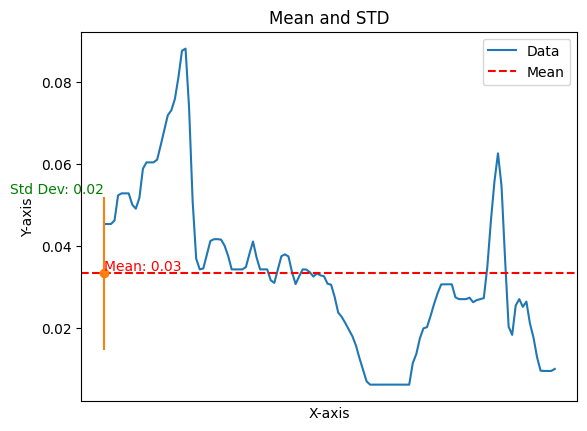

In [13]:
plot_mean_std(a)

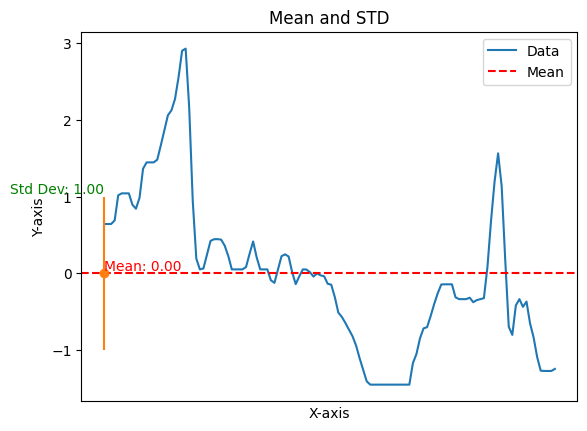

In [14]:
import torch.nn.functional as F

def my_normalize(a):
    return (a - a.mean()) / a.std()

normalized = my_normalize(a)
plot_mean_std(normalized)

let's do normalize again using fastai normalize function as well as the imagenet stats about mean and std

In [15]:
normalized_from_stats = Normalize.from_stats(*imagenet_stats)(x)
normalized_from_stats.mean(dim=[0,2,3]), normalized_from_stats.std(dim=[0,2,3])

(TensorImage([-0.0271,  0.0507,  0.1397], device='cuda:0'),
 TensorImage([1.2312, 1.2298, 1.3158], device='cuda:0'))

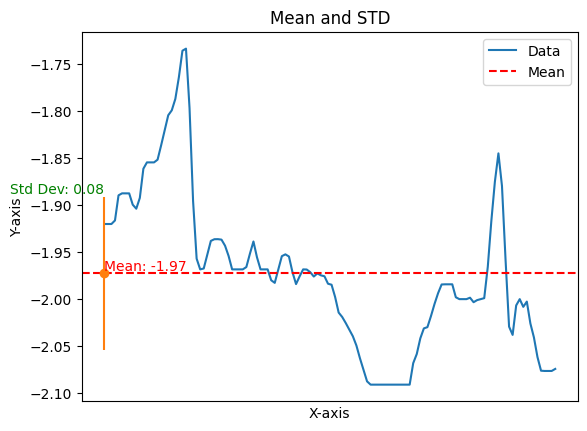

In [16]:
a2 = normalized_from_stats[0][0][0].cpu()
plot_mean_std(a2)

somehow, it's worse?? but that's the recommmended way in the book, to use the stats from imagenet_stats
TBC!!

In [17]:
# before normalization, we had those, save for comparison later
x,y = dls.one_batch()
old_mean = x.mean(dim=[0,2,3])
old_std = x.std(dim=[0,2,3])
old_validate = learn.validate()

In [30]:
# Note the Normalize.from_stats()!
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [31]:
# Let's check what effect this had on training our model:
dls = get_dls(128, 128)
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.552692,2.033636,0.465646,00:29
1,1.260297,1.520756,0.570202,00:29
2,1.008881,1.140249,0.643764,00:28
3,0.784746,0.790237,0.761016,00:28
4,0.637653,0.623757,0.812547,00:29


### Now, let's compare how normalization improved validation loss and accuracy

In [27]:
dls = get_dls(128, 128)
x,y = dls.one_batch()
new_mean = x.mean(dim=[0,2,3])
new_std = x.std(dim=[0,2,3])
new_validate = learn.validate()

print(f'old_mean: {old_mean}, old_std {old_std}')
print(f'new_mean: {new_mean}, new_std {new_std}')


print(f'old validation info: {old_validate}')
print(f'new validation info: {new_validate}')

old_mean: TensorImage([0.4802, 0.4648, 0.4371], device='cuda:0'), old_std TensorImage([0.2708, 0.2656, 0.2876], device='cuda:0')
new_mean: TensorImage([0.0086, 0.0279, 0.0656], device='cuda:0'), new_std TensorImage([1.0286, 1.0240, 1.0069], device='cuda:0')
old validation info: [0.5972703099250793, 0.8110530376434326]
new validation info: [0.61607825756073, 0.8073188662528992]


- new mean are much better (closer to 0)
- std as well
- bit training results are not better lol (but jeremy did say tha we were normalizing was done automatically for us now, so maybe having or not having normalization is the same (when using fastai) then? TBC

# Progressive Resizing

In [21]:
try:
    del learn
    torch.cuda.empty_cache()
    gc.collect()
except: pass

In [22]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy).to_fp16()
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.613904,2.490425,0.403659,00:29
1,1.244034,1.328793,0.604929,00:29
2,0.962905,0.878940,0.715086,00:28
3,0.771246,0.703380,0.774832,00:28


In [23]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.845988,1.026695,0.691561,00:44


epoch,train_loss,valid_loss,accuracy,time
0,0.690574,0.638145,0.789022,00:44
1,0.696446,0.634462,0.793503,00:43
2,0.599846,0.594454,0.809933,00:43
3,0.505655,0.444884,0.856609,00:43
4,0.453520,0.413680,0.863704,00:43


It indeed improves a lot! We had 0.80 before we are now at __0.86__!!